Selected 12 hours between arrival and departure
          Date      Time  prijs_excl_belastingen
0   2024-02-01  18:00:00                 0.11300
1   2024-02-01  19:00:00                 0.09803
2   2024-02-01  20:00:00                 0.09081
3   2024-02-01  21:00:00                 0.08334
4   2024-02-01  22:00:00                 0.08191
5   2024-02-01  23:00:00                 0.07342
6   2024-02-02  00:00:00                 0.06432
7   2024-02-02  01:00:00                 0.05995
8   2024-02-02  02:00:00                 0.05800
9   2024-02-02  03:00:00                 0.05469
10  2024-02-02  04:00:00                 0.05314
11  2024-02-02  05:00:00                 0.05513
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 51 rows, 72 columns and 144 nonzeros
Model fingerprint:

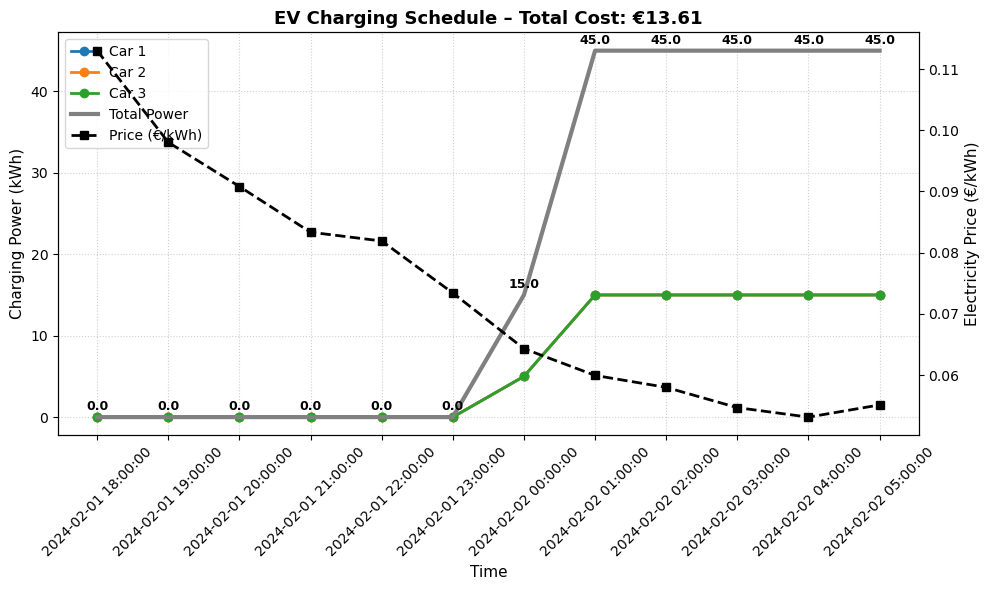

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

# === Load and clean dataset ===
data = pd.read_csv(
    "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv",
    sep=";",
    decimal=",",
    encoding="utf-8-sig"
)

# Split the first column into Date and Time
split = data.iloc[:, 0].astype(str).str.split(r"\s+", n=1, expand=True)
data["Date"] = split[0].str.strip()
data["Time"] = split[1].str.strip()
data["prijs_excl_belastingen"] = data["prijs_excl_belastingen"].astype(float)

# === Filter the relevant time window ===
arrival_date = "2024-02-01"
departure_date = "2024-02-02"
arrival_time = "18:00:00"
departure_time = "06:00:00"

mask = ((data["Date"] == arrival_date) & (data["Time"] >= arrival_time)) | \
       ((data["Date"] == departure_date) & (data["Time"] < departure_time))
window = data.loc[mask].reset_index(drop=True)

if window.empty:
    raise ValueError("No data found for the selected window. Check date/time values.")

print(f"Selected {len(window)} hours between arrival and departure")
print(window[["Date", "Time", "prijs_excl_belastingen"]])

# === Parameters ===
cars = range(3)                     # 3 cars
timesteps = range(len(window))      # hourly timesteps
price = {t: window.loc[t, "prijs_excl_belastingen"] for t in timesteps}

battery_capacity = 100              # kWh
initial_charge = 0.20 * battery_capacity
target_charge = 1.00 * battery_capacity
max_charge_rate = 15                # kW per car
max_total_power = 50                # shared grid limit (kW)

# === Optimization model ===
model = Model("EV_Charging")

charge_power = model.addVars(cars, timesteps, lb=0, ub=max_charge_rate, name="charge")
soc = model.addVars(cars, timesteps, lb=0, ub=battery_capacity, name="soc")

# === Constraints ===
for c in cars:
    for t in timesteps:
        if t == 0:
            model.addConstr(soc[c, t] == initial_charge + charge_power[c, t])
        else:
            model.addConstr(soc[c, t] == soc[c, t-1] + charge_power[c, t])
    model.addConstr(soc[c, len(timesteps) - 1] >= target_charge)

# Shared grid limit
for t in timesteps:
    model.addConstr(sum(charge_power[c, t] for c in cars) <= max_total_power)

# === Objective: minimize total cost ===
model.setObjective(sum(price[t] * charge_power[c, t] for c in cars for t in timesteps), GRB.MINIMIZE)

# === Optimize ===
model.optimize()

# === Results & Visualization ===
if model.status == GRB.OPTIMAL:
    total_cost = model.objVal
    print(f"\n✅ Optimal total cost: €{total_cost:.2f}")

    # Collect results into DataFrame
    results = []
    for c in cars:
        for t in timesteps:
            results.append({
                "Car": f"Car {c+1}",
                "Time": f"{window.loc[t, 'Date']} {window.loc[t, 'Time']}",
                "Charge (kWh)": charge_power[c, t].X
            })
    df_results = pd.DataFrame(results)

    # Pivot: times on x-axis, cars as columns
    pivot_df = df_results.pivot(index="Time", columns="Car", values="Charge (kWh)").fillna(0)
    pivot_df["Total"] = pivot_df.sum(axis=1)

    # === Plot ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left y-axis: charging power per car
    colors = ["tab:blue", "tab:orange", "tab:green"]
    for i, car in enumerate(pivot_df.columns[:-1]):
        ax1.plot(pivot_df.index, pivot_df[car], marker="o", linewidth=2, color=colors[i], label=car)
    ax1.set_xlabel("Time", fontsize=11)
    ax1.set_ylabel("Charging Power (kWh)", fontsize=11)
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(True, linestyle=":", alpha=0.6)

    # Add total power line
    ax1.plot(pivot_df.index, pivot_df["Total"], color="gray", linewidth=3, linestyle="-", label="Total Power")

    # Annotate total per hour
    for i, total in enumerate(pivot_df["Total"]):
        ax1.text(i, total + 0.5, f"{total:.1f}", ha="center", va="bottom", fontsize=9, color="black", weight="bold")

    # Right y-axis: electricity price
    ax2 = ax1.twinx()
    ax2.plot(pivot_df.index, [price[t] for t in timesteps],
             color="black", linestyle="--", linewidth=2, marker="s", label="Price (€/kWh)")
    ax2.set_ylabel("Electricity Price (€/kWh)", fontsize=11, color="black")

    # Titles & legend
    plt.title(f"EV Charging Schedule – Total Cost: €{total_cost:.2f}", fontsize=13, weight="bold")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()


Nu heel jaar en bart zn auto



✅ Average daily cost: €1.40
✅ Total yearly cost (2024): €510.97


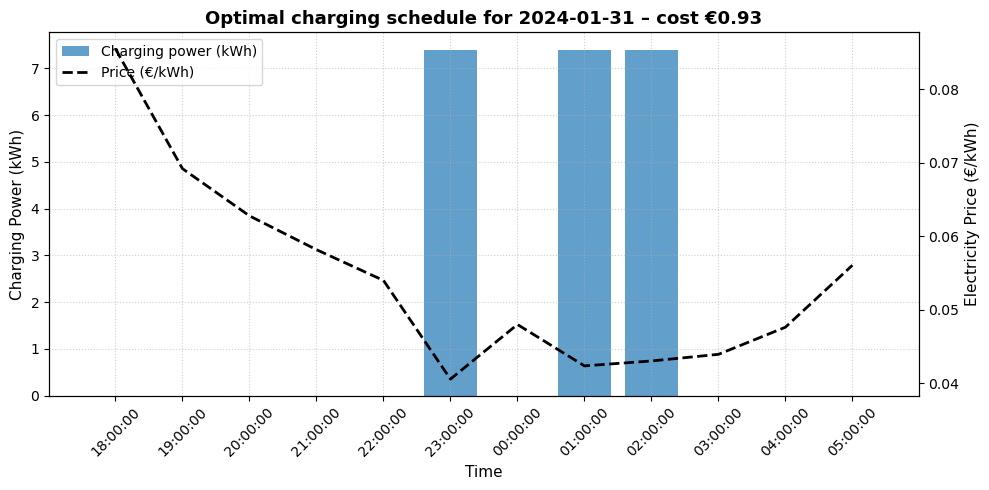

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

# === Load price data ===
data = pd.read_csv(
    "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2024.csv",
    sep=";",
    decimal=",",
    encoding="utf-8-sig"
)

# Split date/time
split = data.iloc[:, 0].astype(str).str.split(r"\s+", n=1, expand=True)
data["Date"] = split[0].str.strip()
data["Time"] = split[1].str.strip()
data["prijs_excl_belastingen"] = data["prijs_excl_belastingen"].astype(float)

# === Parameters ===
battery_needed = 22.2     # kWh needed each night
max_charge_rate = 7.4     # kW limit
arrival_time = "18:00:00"
departure_time = "06:00:00"

# --- Helper to extract 18:00–06:00 window for one night ---
def price_window(date_today, date_tomorrow):
    mask = ((data["Date"] == date_today) & (data["Time"] >= arrival_time)) | \
           ((data["Date"] == date_tomorrow) & (data["Time"] < departure_time))
    window = data.loc[mask].reset_index(drop=True)
    return window

# === Loop through all days in 2024 ===
unique_dates = sorted(data["Date"].unique())
daily_costs, schedules = [], []

for i in range(len(unique_dates) - 1):
    day = unique_dates[i]
    window = price_window(unique_dates[i], unique_dates[i + 1])
    if window.empty:
        continue

    # Setup model for this night
    timesteps = range(len(window))
    price = {t: window.loc[t, "prijs_excl_belastingen"] for t in timesteps}

    model = Model()
    charge = model.addVars(timesteps, lb=0, ub=max_charge_rate, name="charge")

    # Must deliver exactly required energy
    model.addConstr(sum(charge[t] for t in timesteps) == battery_needed)

    # Minimize total cost
    model.setObjective(sum(price[t] * charge[t] for t in timesteps), GRB.MINIMIZE)
    model.setParam("OutputFlag", 0)
    model.optimize()

    # Store results
    daily_costs.append({"Date": day, "Cost (€)": model.objVal})
    schedules.append({
        "Date": day,
        "Times": list(window["Time"]),
        "Prices": list(window["prijs_excl_belastingen"]),
        "Schedule": [charge[t].X for t in timesteps]
    })

# === Combine results ===
df_costs = pd.DataFrame(daily_costs)
total_year_cost = df_costs["Cost (€)"].sum()
avg_day_cost = df_costs["Cost (€)"].mean()

print(f"\n✅ Average daily cost: €{avg_day_cost:.2f}")
print(f"✅ Total yearly cost (2024): €{total_year_cost:.2f}")

# === Example day visualization ===
example_day = schedules[30]  # roughly early February
times = example_day["Times"]
prices = example_day["Prices"]
charge = example_day["Schedule"]
cost_example = df_costs.loc[df_costs["Date"] == example_day["Date"], "Cost (€)"].values[0]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(times, charge, color="tab:blue", alpha=0.7, label="Charging power (kWh)")
ax1.set_ylabel("Charging Power (kWh)", fontsize=11)
ax1.set_xlabel("Time", fontsize=11)
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, linestyle=":", alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(times, prices, color="black", linestyle="--", linewidth=2, label="Price (€/kWh)")
ax2.set_ylabel("Electricity Price (€/kWh)", fontsize=11)

plt.title(f"Optimal charging schedule for {example_day['Date']} – cost €{cost_example:.2f}",
          fontsize=13, weight="bold")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()
